# **Random Forest Model**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Complete code for the Random Forest Regression model

# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Load datasets
water_quality_data = pd.read_csv('/content/drive/MyDrive/Digital_Project/Finaldata/Daily_Water_Quality_Data_with_Day_Adjusted with DAY.csv')
historical_data = pd.read_excel('/content/drive/MyDrive/Digital_Project/Finaldata/Final updated_Daily historical data final.xlsx')
merged_data = pd.read_csv('/content/drive/MyDrive/Digital_Project/Finaldata/Merged_Cleaned_data_2014_to_2023.csv')

# Preprocessing: Ensure date compatibility and merge datasets
water_quality_data['Date'] = pd.to_datetime(water_quality_data['Date'])
historical_data['Date'] = pd.to_datetime(historical_data['Date'])
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

# Drop duplicate or irrelevant columns before merging
historical_data = historical_data.drop(columns=['Year', 'Day'], errors='ignore')
merged_data = merged_data.drop(columns=['Year', 'Day'], errors='ignore')

# Merge datasets based on 'Day_of_Year'
merged_dataset = (
    water_quality_data
    .merge(historical_data, left_on='Day_of_Year', right_on='Day_of_Year', how='inner')
    .merge(merged_data, left_on='Day_of_Year', right_on='Day_of_Year', how='inner')
)

# Target variable
target_column = "Discharge(flow) in cubic meters per second (m3/s) "

# Prepare features and target
features = merged_dataset.drop(
    columns=['Sample Date', 'Date/Time_x', 'Date/Time_y', 'Day', target_column], errors='ignore'
)
target = merged_dataset[target_column]

# Select only numeric features
features = features.select_dtypes(include=['float64', 'int64'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train a Random Forest Regressor with reduced estimators for optimization
rf_model_optimized = RandomForestRegressor(n_estimators=20, random_state=42)
rf_model_optimized.fit(X_train, y_train)

# Predict on the test set
y_pred_optimized = rf_model_optimized.predict(X_test)

# Evaluate the model's performance
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)


# Display results
print('MSE = ', mse_optimized)
print('R² = ', r2_optimized)

MSE =  4.817598739035445
R² =  0.9982026777455147


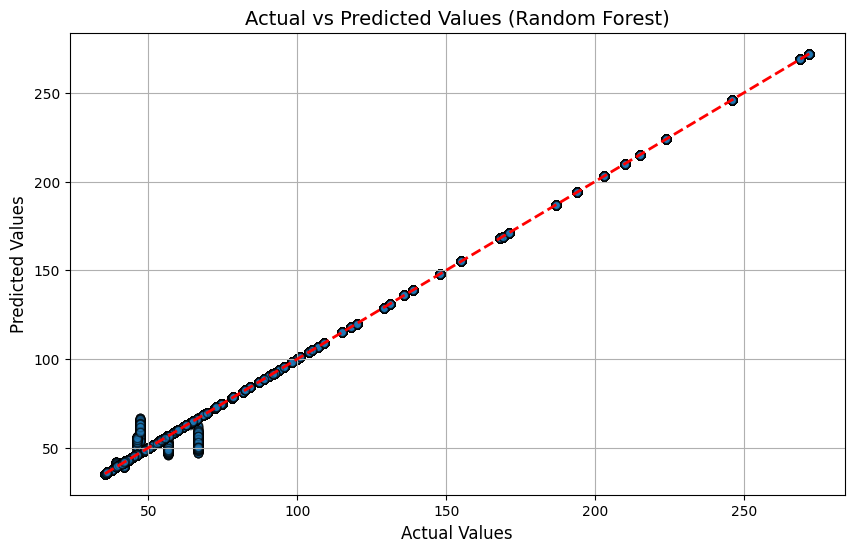

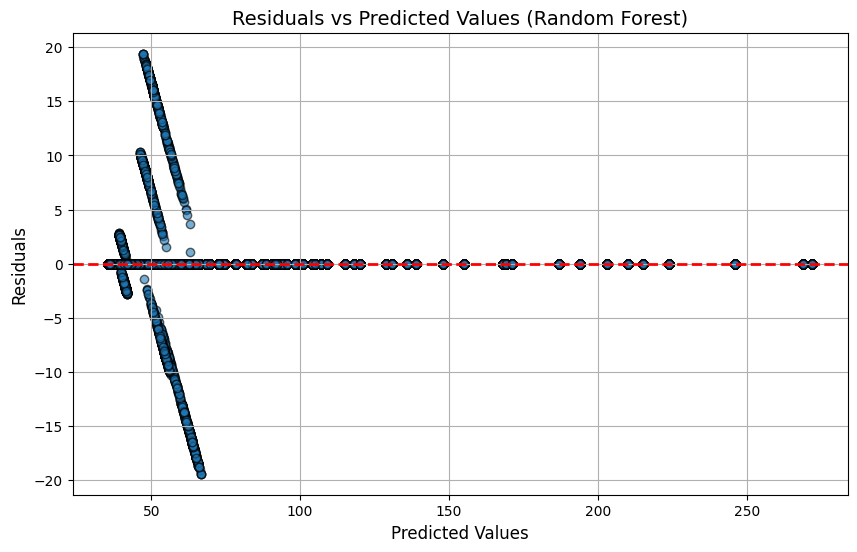

In [8]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values for Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_optimized, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Actual vs Predicted Values (Random Forest)', fontsize=14)
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.grid(True)
plt.show()

# Compute residuals for Random Forest
residuals = y_test - y_pred_optimized

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_optimized, residuals, alpha=0.6, edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.title('Residuals vs Predicted Values (Random Forest)', fontsize=14)
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.grid(True)
plt.show()


# **Using K4 Fold Split Method**

In [14]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ensure the 'Year' column is present in the dataset
if 'Year' not in merged_dataset.columns:
    merged_dataset['Year'] = pd.to_datetime(merged_dataset['Date']).dt.year

# Define the target column and feature columns
target_column = "Discharge(flow) in cubic meters per second (m3/s) "
feature_columns = merged_dataset.select_dtypes(include=['float64', 'int64']).columns.drop(
    ['Year', target_column], errors='ignore'
)

# Function for K4 method including MSE
def k4_random_forest_with_mse(data, target_column, feature_columns):
    results = []
    years = sorted(data['Year'].unique())

    for i in range(0, len(years) - 3, 2):  # 2-year training, 2-year testing
        train_years = years[i:i+2]
        test_years = years[i+2:i+4]

        train_data = data[data['Year'].isin(train_years)]
        test_data = data[data['Year'].isin(test_years)]

        X_train = train_data[feature_columns]
        y_train = train_data[target_column]
        X_test = test_data[feature_columns]
        y_test = test_data[target_column]

        rf_model = RandomForestRegressor(n_estimators=20, random_state=42)
        rf_model.fit(X_train, y_train)

        y_pred = rf_model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results.append({'Train Years': train_years, 'Test Years': test_years, 'MSE': mse, 'R²': r2})

    return results

# Apply the K4 method with MSE
k4_results_with_mse = k4_random_forest_with_mse(merged_dataset, target_column, feature_columns)

# Convert results to a DataFrame
k4_results_with_mse_df = pd.DataFrame(k4_results_with_mse)

print(k4_results_with_mse_df)

    Train Years    Test Years       MSE        R²
0  [2014, 2015]  [2016, 2017]  3.989002  0.998524
1  [2016, 2017]  [2018, 2019]  4.100082  0.998482
2  [2018, 2019]  [2020, 2021]  2.548726  0.999057
3  [2020, 2021]  [2022, 2023]  5.276237  0.998046


In [18]:
# Function to calculate the overall MSE and R²
def calculate_overall_metrics(k4_results):
    mse_values = [result['MSE'] for result in k4_results]
    r2_values = [result['R²'] for result in k4_results]

    overall_mse = sum(mse_values) / len(mse_values)
    overall_r2 = sum(r2_values) / len(r2_values)

    return overall_mse, overall_r2

# Calculate overall metrics
overall_mse, overall_r2 = calculate_overall_metrics(k4_results_with_mse)

# Print the overall results
print(f"Overall Mean Squared Error (MSE): {overall_mse}")
print(f"Overall R-Squared (R²): {overall_r2}")


Overall Mean Squared Error (MSE): 3.9785117174531366
Overall R-Squared (R²): 0.9985273421453769


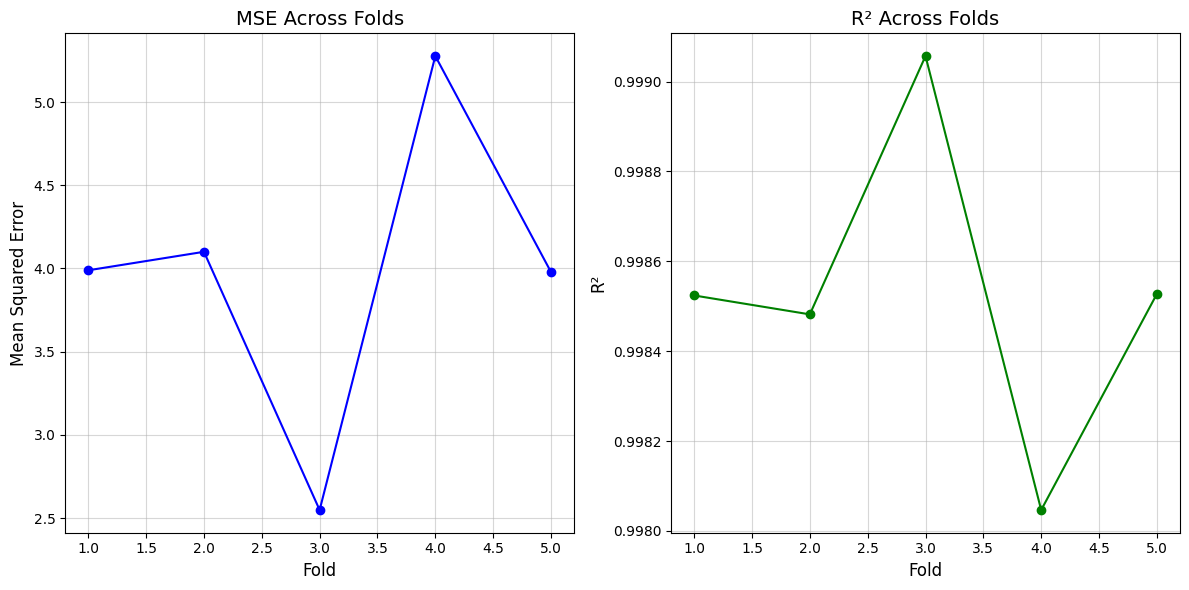

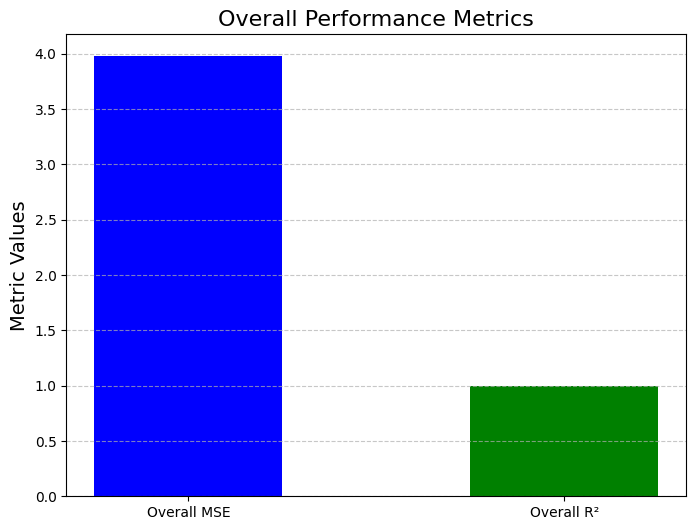

In [19]:
# Prepare data for visualization
mse_values = [result['MSE'] for result in k4_results_with_mse]
r2_values = [result['R²'] for result in k4_results_with_mse]
folds = range(1, len(k4_results_with_mse) + 1)

# Visualizing MSE and R² for each fold
plt.figure(figsize=(12, 6))

# Plot MSE for each fold
plt.subplot(1, 2, 1)
plt.plot(folds, mse_values, marker='o', linestyle='-', label='MSE', color='blue')
plt.title('MSE Across Folds', fontsize=14)
plt.xlabel('Fold', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.grid(alpha=0.5)

# Plot R² for each fold
plt.subplot(1, 2, 2)
plt.plot(folds, r2_values, marker='o', linestyle='-', label='R²', color='green')
plt.title('R² Across Folds', fontsize=14)
plt.xlabel('Fold', fontsize=12)
plt.ylabel('R²', fontsize=12)
plt.grid(alpha=0.5)

# Display the plots
plt.tight_layout()
plt.show()

# Overall MSE and R² as a bar chart
overall_metrics = ['Overall MSE', 'Overall R²']
overall_values = [overall_mse, overall_r2]

plt.figure(figsize=(8, 6))
plt.bar(overall_metrics, overall_values, color=['blue', 'green'], width=0.5)
plt.title("Overall Performance Metrics", fontsize=16)
plt.ylabel("Metric Values", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


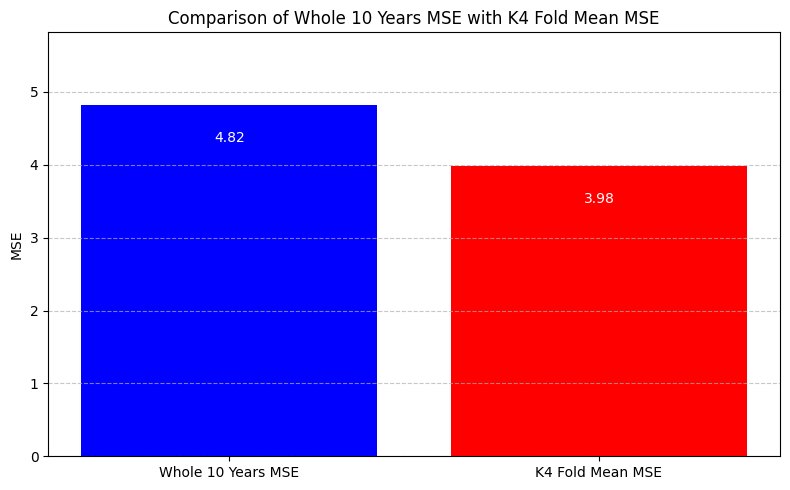

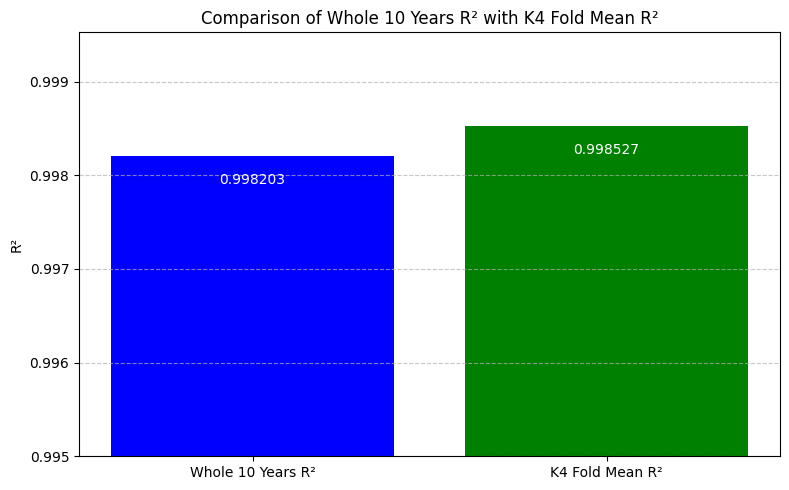

In [6]:
# Visual comparison for MSE with updated labels
plt.figure(figsize=(8, 5))
bars = plt.bar(['Whole 10 Years MSE', 'K4 Fold Mean MSE'], [individual_mse, overall_mse], color=['blue', 'red'])
plt.title('Comparison of Whole 10 Years MSE with K4 Fold Mean MSE')
plt.ylabel('MSE')
plt.ylim(0, max(individual_mse, overall_mse) + 1)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.5, f"{bar.get_height():.2f}", ha='center', color='white')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Visual comparison for R² with updated labels
plt.figure(figsize=(8, 5))
bars = plt.bar(['Whole 10 Years R²', 'K4 Fold Mean R²'], [individual_r2, overall_r2], color=['blue', 'green'])
plt.title('Comparison of Whole 10 Years R² with K4 Fold Mean R²')
plt.ylabel('R²')
plt.ylim(0.995, max(individual_r2, overall_r2) + 0.001)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.0003, f"{bar.get_height():.6f}", ha='center', color='white')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
